In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [28]:
# Load and read the datasets 
athlete_events = pd.read_csv('../athlete_events.csv')
noc_regions = pd.read_csv('../noc_regions.csv')

# Merge the datasets on the 'NOC' column
merged_data = athlete_events.merge(noc_regions, on='NOC', how='left')

# Check for missing values in the 'region' column
missing_regions = merged_data['region'].isnull().sum()

missing_values = merged_data.isnull().sum()

# Drop irrelevant columns (such as 'notes')
cleaned_data = merged_data.drop(columns=['notes'])

# Handle missing values for 'Medal'
cleaned_data['Medal'] = cleaned_data['Medal'].fillna('No Medal')

# Remove duplicate rows
cleaned_data = cleaned_data.drop_duplicates()

# Standardize text data (lowercase for consistency)
cleaned_data['Sex'] = cleaned_data['Sex'].str.lower()
cleaned_data['Sport'] = cleaned_data['Sport'].str.lower()

# Add a binary column for medal presence
cleaned_data['Medal_Won'] = cleaned_data['Medal'].apply(lambda x: 0 if x == 'No Medal' else 1)

# Check for missing values after cleaning
missing_values_after_cleaning = cleaned_data.isnull().sum()

# Getting mean value depending on the gender
gender_means = cleaned_data.groupby('Sex')[['Height', 'Weight']].mean().round(1)

for gender in cleaned_data['Sex'].unique():
    gender_mask = cleaned_data['Sex'] == gender

    # Fill height
    height_mask = gender_mask & cleaned_data['Height'].isna()
    cleaned_data.loc[height_mask, 'Height'] = gender_means.loc[gender, 'Height']

    # Fill weight
    weight_mask = gender_mask & cleaned_data['Weight'].isna()
    cleaned_data.loc[weight_mask, 'Weight'] = gender_means.loc[gender, 'Weight']

# Round Data to one decimal
cleaned_data[['Height', 'Weight']] = cleaned_data[['Height', 'Weight']].round(1)


print(gender_means)
print()
cleaned_data.head()

     Height  Weight
Sex                
f     167.8    60.0
m     178.9    75.7



,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,Medal_Won
0,1,A Dijiang,m,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,basketball,Basketball Men's Basketball,No Medal,China,0
1,2,A Lamusi,m,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,judo,Judo Men's Extra-Lightweight,No Medal,China,0
2,3,Gunnar Nielsen Aaby,m,24.0,178.9,75.7,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,football,Football Men's Football,No Medal,Denmark,0
3,4,Edgar Lindenau Aabye,m,34.0,178.9,75.7,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,tug-of-war,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,1
4,5,Christine Jacoba Aaftink,f,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,speed skating,Speed Skating Women's 500 metres,No Medal,Netherlands,0


In [13]:
## Converts Male to 1 and Female to 0
le = LabelEncoder()
sex = le.fit_transform(cleaned_data['Sex'])
cleaned_data.drop("Sex", axis=1, inplace=True)
cleaned_data["Sex"] = sex
cleaned_data.head()

,ID,Name,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,Medal_Won,Sex
0,1,A Dijiang,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,basketball,Basketball Men's Basketball,No Medal,China,0,1
1,2,A Lamusi,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,judo,Judo Men's Extra-Lightweight,No Medal,China,0,1
2,3,Gunnar Nielsen Aaby,24.0,178.9,75.7,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,football,Football Men's Football,No Medal,Denmark,0,1
3,4,Edgar Lindenau Aabye,34.0,178.9,75.7,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,tug-of-war,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,1,1
4,5,Christine Jacoba Aaftink,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,speed skating,Speed Skating Women's 500 metres,No Medal,Netherlands,0,0


# Data Exploration

- Q1. Which countries tend to win the most medals, and why?
- Q2. Which sports contribute the most to a country's overall medal count?

In [16]:
medal_per_country = cleaned_data[['region', 'Medal', 'Medal_Won']].copy()
medal_per_country.head()

,region,Medal,Medal_Won
0,China,No Medal,0
1,China,No Medal,0
2,Denmark,No Medal,0
3,Denmark,Gold,1
4,Netherlands,No Medal,0


In [54]:
count_medals = cleaned_data[cleaned_data['Medal_Won'] == 1]['region'].value_counts()
top_countries = count_medals.head(5)
print(top_countries)

region
USA        5637
Russia     3947
Germany    3756
UK         2067
France     1767
Name: count, dtype: int64


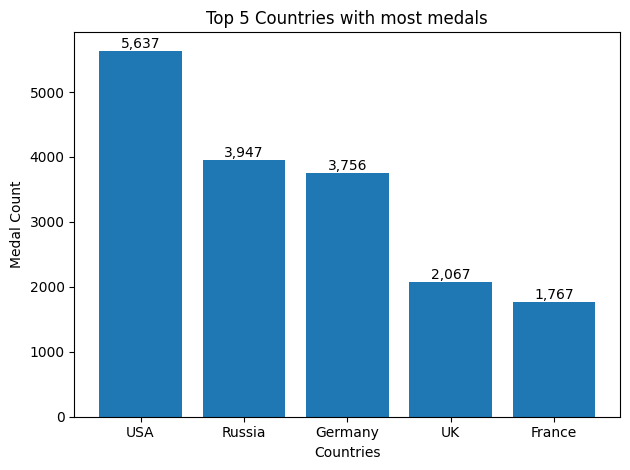

In [53]:
fig, ax = plt.subplots()
plt.title("Top 5 Countries with most medals")
# Assign x and y coordinates
bars = ax.bar(top_countries.index , top_countries.values)

# Add x and y labels
plt.xlabel("Countries")
plt.ylabel("Medal Count")

# Go through each bar and add its value on top of it
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Observations

We can observe that the top 5 countries are mostly countries that are economically powerful, being USA the world power and getting the most amount of medals

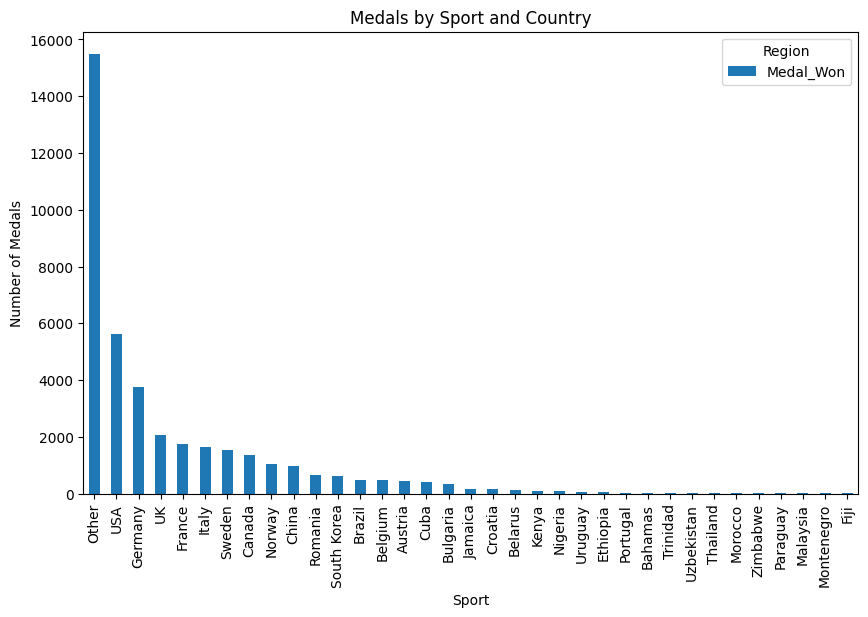

In [61]:
sport_medals = cleaned_data[cleaned_data['Medal_Won'] == 1].groupby(['Sport', 'region'])['Medal_Won'].count().reset_index()

# Grouping regions with less medals than threshold to other
threshold = 10
sport_medals['region'] = sport_medals['region'].apply(lambda x: x if sport_medals[sport_medals['region'] == x]['Medal_Won'].values[0] >= threshold else 'Other')
aggregated = sport_medals.groupby('region')['Medal_Won'].sum().sort_values(ascending=False)
aggregated.plot(kind='bar', figsize=(10,6))
plt.title('Medals by Sport and Country')
plt.ylabel('Number of Medals')
plt.xlabel('Sport')
plt.legend(title='Region')
plt.show()

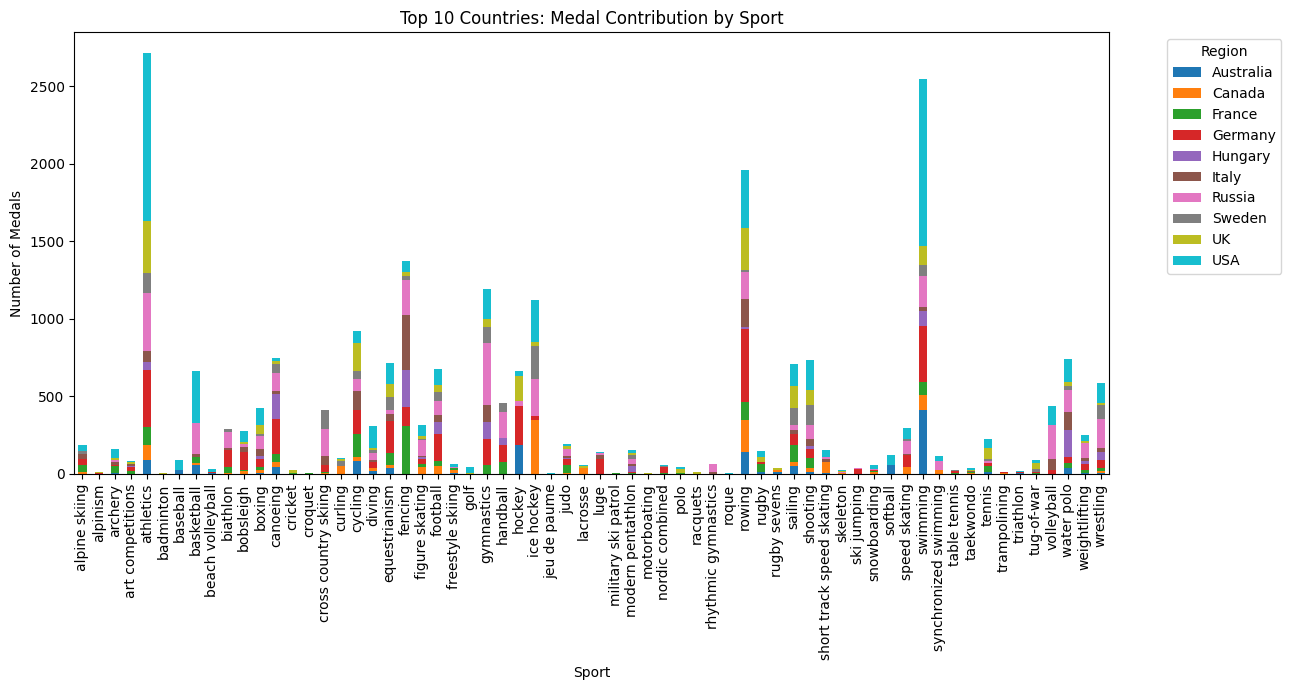

In [70]:
country_medals = cleaned_data[cleaned_data['Medal_Won'] == 1].groupby('region')['Medal_Won'].count().reset_index()
top_countries = country_medals.nlargest(10, 'Medal_Won')['region']

# Filter dataset for top countries
filtered_df = cleaned_data[cleaned_data['region'].isin(top_countries)]

# Re-aggregate by sport and region
filtered_sport_medals = filtered_df[filtered_df['Medal_Won'] == 1].groupby(['Sport', 'region'])['Medal_Won'].count().reset_index()
sport_medals_pivot = filtered_sport_medals.pivot(index='Sport', columns='region', values='Medal_Won').fillna(0)

# Plot
sport_medals_pivot.plot(kind='bar', stacked=True, figsize=(13, 7))
plt.title("Top 10 Countries: Medal Contribution by Sport")
plt.ylabel("Number of Medals")
plt.xlabel("Sport")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()